## Library & Framework

This project using fastaiv1

In [28]:
# from fastai.vision import *
# from fastai.callbacks.hooks import *
# import timm

from fastprogress import progress_bar
import pandas as pd
import numpy as np
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pydicom
from matplotlib import pyplot as plt

## group sklearn

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.utils import class_weight
## group torch

import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler


Variable config as a hyper-parametters object

In [3]:
config = {}

config['project_path'] = '/kaggle/input/rsna-pneumonia-detection-challenge'
config['img_input'] = os.path.join(config['project_path'],'stage_2_train_images')
config['working'] = '/kaggle/working'


config['size'] = 256

config['batch_size'] = 24

config['num_workers'] = 10

config['num_classes'] = 2
config['epochs'] = 2
config['lr'] = 1e-3
config['sch_lr'] = 0.9

config['step_size_lr'] = 1

config['pool'] = 6500

config['nb_iterations'] = 3

config['num_gist'] = 200

config['initial_decay_rate'] = 0.1
config['decay_rate'] = 0.1
config['thresh'] = None

config['discrim_ratio'] = 0.2

config['muy'] = 0.5

config['ite_momentum'] = 5

config['thres_momentum'] = 0.8

config['valid_ratio'] = 0.1

config['thres'] = 0.5

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Prepare Dataframe

In [5]:
def prepare_dataframe(config):
    
    df_ = pd.read_csv(os.path.join(config['project_path'],'stage_2_detailed_class_info.csv')).drop_duplicates(subset='patientId').reset_index(drop=True)
    
    df_['target'] = [1 if item == 'Lung Opacity' else 0 for item in list(df_['class'])]
    
    df_full, df_anno_valid = train_test_split(df_, test_size = config['valid_ratio'],random_state=0)
        
    df_anno_full, df_not_anno_full = train_test_split(df_full, test_size = config['anno_ratio'],random_state=0)
    
    df_not_anno_full['target'] = 0
    
    df_anno_used, _ = train_test_split(df_anno_full,test_size = (1 - config['used']/len(df_anno_full)))
    
    df_anno_train = df_anno_used.reset_index(drop=True)
    
    df_not_anno = df_not_anno_full

    df_anno_train['is_valid'] = False
    df_anno_train['is_anno'] = True
    df_anno_train['is_track'] = False
    df_anno_train['past_score'] = 0

    df_anno_valid['is_valid'] = True
    df_anno_valid['is_anno'] =True
    df_anno_valid['is_track'] = False
    df_anno_valid['past_score'] = 0

    df_not_anno['is_valid'] = False
    df_not_anno['is_anno'] = False
    df_not_anno['is_track'] = False
    df_not_anno['past_score'] = 0

    df_concat = pd.concat([df_anno_train,df_anno_valid,df_not_anno]).reset_index(drop=True)
    
    print('Prepare dataframe: Done')
    
    return df_concat

In [6]:
def load_dicom(fname):
    
    fname = fname + '.dcm'
    
    dicom = pydicom.read_file(fname)
    data = dicom.pixel_array
    
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    
    img_array = (data * 255).astype(np.uint8)
    
    return img_array

In [7]:
class pneuDataset(Dataset):
    def __init__(self, dir_path, df, transforms=None, is_anno = True):
        """
        param:
            dir_path: is path of images
            df: dataframe            
            transform:
            is_pool: anno/unanno
        return:
            img, fname, anno
        """
        self.transforms = transforms

        self.dir_path = dir_path

        self.imgs = list(df['patientId'])
        
        self.annos = [np.array([item]) for item in list(df['target'])]
        
        self.is_anno = is_anno
        
    def __getitem__(self, idx):
        
        fname = os.path.join(self.dir_path, self.imgs[idx])
        
        img_array = load_dicom(fname)
        
        img = Image.fromarray(np.uint8(img_array)).convert('RGB')
                
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.is_anno:
            return img, self.imgs[idx], self.annos[idx]
        else:
            return img, self.imgs[idx]
    
    def __len__(self):
        return len(self.imgs)

In [8]:
def create_dls(df_concat):
    """
    custom dataset & dataloader
    param:
        df_concat: df_concat update follow iterations
    return:
        train_dl, valid_dl, pool_dl
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
                        transforms.Resize((config['size'],config['size'])),
                        transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

    valid_transforms = transforms.Compose([
                        transforms.Resize((config['size'],config['size'])),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])



    df_anno_train = df_concat[(df_concat['is_anno']==True)&(df_concat['is_valid']==False)
                                    ].reset_index(drop=True)
    anno_train_ds = pneuDataset(
                            dir_path = os.path.join(config['project_path'],'stage_2_train_images'),
                            df = df_anno_train,
                            transforms = train_transforms,
                            is_anno = list(set(df_anno_train['is_anno']))[0]
                        )

    df_anno_valid = df_concat[(df_concat['is_anno']==True)&(df_concat['is_valid']==True)
                                        ].reset_index(drop=True)
    anno_valid_ds = pneuDataset(
                            dir_path = os.path.join(config['project_path'],'stage_2_train_images'),
                            df = df_anno_valid,
                            transforms = valid_transforms,
                            is_anno = list(set(df_anno_valid['is_anno']))[0]
                        )
    
    ## full instances in pool
    
    df_pool = df_concat[df_concat['is_anno']==False].reset_index(drop=True)
            
    df_pool_sampling = df_pool.sample(config['pool']).reset_index(drop=True)

    pool_ds = pneuDataset(
                            dir_path = os.path.join(config['project_path'],'stage_2_train_images'),
                            df = df_pool_sampling,
                            transforms = valid_transforms,
                            is_anno = list(set(df_pool_sampling['is_anno']))[0]
                        )

    anno_train_dl = DataLoader(
                        anno_train_ds, 
                        batch_size=config['batch_size'], 
                        num_workers=config['num_workers']
                        )
    anno_valid_dl = DataLoader(
                        anno_valid_ds, 
                        batch_size=config['batch_size'], 
                        num_workers=config['num_workers']
                        )
    
    pool_dl = DataLoader(
                        pool_ds, 
                        batch_size=config['batch_size'], 
                        num_workers=config['num_workers']
                        )
    
    print('Train {0} neg / {1} pos'.format(
        str(np.concatenate(anno_train_dl.dataset.annos,axis=0).tolist().count(0)),
        str(np.concatenate(anno_train_dl.dataset.annos,axis=0).tolist().count(1))))
    
    print('Valid {0} neg / {1} pos'.format(
        str(np.concatenate(anno_valid_dl.dataset.annos,axis=0).tolist().count(0)),
        str(np.concatenate(anno_valid_dl.dataset.annos,axis=0).tolist().count(1))))
    
    print('Sampling Pool {} instances'.format(len(pool_dl.dataset.imgs)))

    return anno_train_dl, anno_valid_dl, pool_dl

In [9]:
# config['pool']

In [10]:
class customNet(nn.Module):
    
    def __init__(self, output_nodes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=256),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=output_nodes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [11]:
def moving_avg(past_score , model_score, muy = config['muy']):
    return muy*past_score + (1-muy)*model_score

def entropy(scores):
    en = np.zeros(len(scores))
    for idx in tqdm(range(0, len(scores))):
        en[idx] = -scores[idx] * np.log(scores[idx])
    return en

def certain_set(en, thresh, initial_decay_rate, decay_rate):
    # Threshold updating <-- review
    if thresh == None:
        thresh = max(en) - ((max(en) - min(en)) * initial_decay_rate)
    else:
        thresh = thresh + (max(en) - thresh) * decay_rate

    return np.where(en < thresh)[0], thresh

def moment_track_score(df, score_fnames):
    """
    update confidence score by file names into df_concat
    change is_track
    if is_track == True --> use previous confidence score in df_concat
    else previous confidence == current confidence
    param:
        df: df_concat
        zip_conf_fnames: zip(confidence_score, fnames)
    return:
        df_concat
    """
    
    for model_score, fname in score_fnames:
        
        if df.loc[df['patientId'] == fname, 'is_track'] is True:  
            past_score = df.loc[df['patientId'] == fname, 'past_score'].iloc[0]
            df.loc[df['patientId'] == fname, 'past_score'] = moving_avg(past_score , model_score)
        else:
            df.loc[df['patientId'] == fname, 'is_track'] = True
            df.loc[df['patientId'] == fname, 'past_score'] = model_score


In [12]:
def train_one(model, optimizer, device, dataloader, df, is_goal=False, balance = True):
    """
    train one epoch
    param:
        model
        optimizer
        criterion
        device
        dataloader
        df: df_concat to track past_score
    """
    
    categories = np.concatenate(dataloader.dataset.annos,axis=0)
    class_weights = class_weight.compute_class_weight('balanced',np.unique(categories).tolist(),categories)
    class_weights = torch.tensor(class_weights[1]/class_weights[0],dtype=torch.float).to(device)
    
    if balance:
        criterion = nn.BCELoss(weight = class_weights)
    else:
        criterion = nn.BCELoss()

    model = model.train()
    model = model.to(device)
    
    loss_one_epoch = []
    
    for imgs, fnames, targets in progress_bar(dataloader):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        conf_scores = model(imgs)
#         optimizer.zero_grad()
        
        if is_goal:
            model_scores = conf_scores.cpu().detach().numpy().tolist()
            model_scores = [item[0] for item in model_scores]
            score_fnames = list(zip(model_scores,fnames))
            moment_track_score(df, score_fnames)

            ## get score from df
            moment_scores = []
            for fname in fnames:
                m_score = df.loc[df['patientId'] == fname, 'past_score'].iloc[0]
                moment_scores.append([m_score])
            moment_scores = torch.tensor(moment_scores,requires_grad=True).type(torch.float)
            moment_scores = moment_scores.to(device)
            loss_batch = criterion(moment_scores, targets.type(torch.float))
            
        else:
            loss_batch = criterion(conf_scores, targets.type(torch.float))

        loss_batch.backward()
        optimizer.step()
        
        loss_one_epoch.append(loss_batch.item())
    
    loss_one_epoch_mean = np.mean(loss_one_epoch)
    
    return loss_one_epoch_mean

def eval_one(model, device, dataloader, thres = config['thres']):
    
    loss_one_epoch = []
    
    criterion = nn.BCELoss()
    
    model.eval()
    with torch.no_grad():
        list_conf_score = []
        list_targets = []
        list_fnames = []

        for imgs, fnames, targets in progress_bar(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            conf_scores = model(imgs)
            
            loss_batch = criterion(conf_scores, targets.type(torch.float))
            loss_one_epoch.append(loss_batch.item())
            
            list_conf_score.extend(conf_scores.cpu().numpy())
            
            list_targets.extend(targets.cpu().numpy())
            list_fnames.extend(fnames)
        
        y_pred = np.array(list_conf_score)
        y_true = np.array(list_targets)
        y_pred = (y_pred >= thres).astype(np.uint8)
        
        f1 = metrics.f1_score(y_true, y_pred, average='binary')
        
        loss_one_epoch_mean = np.mean(loss_one_epoch)
        
        list_conf_score = [item.item() for item in list_conf_score]
        
    return list_conf_score, list_fnames, loss_one_epoch_mean, f1

def pred_pool(model, device, dataloader, thres = 0.5):
    
    model.eval()
    with torch.no_grad():
        list_conf_score = []
        list_fnames = []
        for imgs, fnames in progress_bar(dataloader):
            imgs = imgs.to(device)
            conf_scores = model(imgs)
            
            list_conf_score.extend(conf_scores.cpu().numpy())
            list_fnames.extend(fnames)
                        
        list_conf_score = np.array([item.item() for item in list_conf_score])
        pred_categories = (list_conf_score >= thres).astype(np.uint8)
        
    return list_conf_score, list_fnames, pred_categories

In [13]:
# from matplotlib import pyplot as plt
# plt.plot(list(range(len(list_conf_score))),np.sort(en))

In [14]:
def feature_extractor(model, dataloader, is_train = True):
    
    backbone = nn.Sequential(*list(model.base_model.children())[:-1])
    
    list_features = []
    list_categories = []
    
    fnames = []
    
    if is_train:
        for x, f, y in progress_bar(dataloader):
            x, y = x.cuda(), y.cuda()
            backbone = backbone.cuda()

            feature = backbone(x).detach().cpu().squeeze()
            
#             list_features.append(feature)

            if len(feature.shape) == 2:
                list_features.extend(feature.numpy())
            else:
                list_features.extend(np.expand_dims(feature.numpy(),axis=0))

            list_categories.extend(y.detach().cpu())
            
            fnames += f

#         features = np.concatenate(list_features,axis=0)
#         categories = np.concatenate(list_categories,axis=0)

        features = list_features
        categories = list_categories
        
        return features, fnames, categories
    
    else:
        for x, f in progress_bar(dataloader):
            x  = x.cuda()
            backbone = backbone.cuda()

            feature = backbone(x).detach().cpu().squeeze()

            if len(feature.shape) == 2:
                list_features.extend(feature.numpy())
            else:
                list_features.extend(np.expand_dims(feature.numpy(),axis=0))
            
            fnames += f
            
#         features = np.concatenate(list_features,axis=0)

        features = list_features
        
        return features, fnames

In [15]:
def gist_clustering(
        feature_gist, 
        fnames_gist, 
        category_gist,
        feature_train, 
        categories_train):
    
    pos_idx = np.where(np.array(categories_train) == 1)[0]
    neg_idx = np.where(np.array(categories_train) == 0)[0]

    pos_feature = np.array(feature_train)[pos_idx]
    neg_feature = np.array(feature_train)[neg_idx]
    
#     print(categories_train,categories_train.shape)
    all_vectors = np.concatenate([pos_feature, neg_feature])
    
    kmeans = KMeans(n_clusters = 2 ,random_state=0).fit(all_vectors)
    labels = kmeans.predict(all_vectors)
    
    centroids = kmeans.cluster_centers_
    
    gist_distances= []
    
    pos_centroid = np.mean(pos_feature,axis=0)
    
    neg_centroid = np.mean(neg_feature,axis=0)
    
    ## verify centroids
    
    verify_centroids = {}
    
    if np.linalg.norm(pos_centroid-centroids[0]) < np.linalg.norm(pos_centroid-centroids[1]):
        pos_centroid = centroids[0]
        neg_centroid = centroids[1]
    else:
        pos_centroid = centroids[1]
        neg_centroid = centroids[0]
    
    kmeans_preds_class = kmeans.predict(np.array(feature_gist))
    
    cmp_categories = np.array(category_gist) == np.array(kmeans_preds_class)
    
    fnames_verify = np.array(fnames_gist)[cmp_categories]
    
    categories_verify = np.array(category_gist)[cmp_categories]
    
    return fnames_verify, categories_verify

In [16]:
def gist_selection(X_gist_set, model, category_gist, anno_train_dl, pool_dl):
    
    feature_train, fnames_train, categories_train = feature_extractor(model, anno_train_dl, is_train = True)

    feature_gist, fnames_gist = feature_extractor(model, pool_dl, is_train = False)
    
    X_gist, y_gist = gist_clustering(
                    feature_gist, 
                    fnames_gist, 
                    category_gist,
                    feature_train, 
                    categories_train)
    
    return X_gist, y_gist

In [17]:
def query_update(df, fnames, labels):
    
    ## Update df_concat & move image from pool --> used
    
    for fname, label in tqdm(zip(fnames, labels),total = len(fnames)):

        df.loc[df['patientId'] == fname, 'target'] = label
        df.loc[df['patientId'] == fname, 'is_valid'] = False
        df.loc[df['patientId'] == fname, 'is_anno'] = True
    
    print('Pseudo-labeling {} instances: Done'.format(len(fnames)))
    print('In pool {} instances'.format(len(df[df['is_anno']==False])))
    
    return df

In [18]:
for ratio in sorted(list(np.array(list(range(3,9)))*0.1),reverse=True)[:1]:

    config['used'] = int((1-ratio)*24000)
    config['anno_ratio'] = ratio
    config['thresh'] = None

    print('='*80)
    print('Experiments with {} samples annotation'.format(str(config['used'])))

    df_concat = prepare_dataframe(config)

    fnames, labels = [], [] 

    for ite in range(config['nb_iterations']):

        if len(df_concat[df_concat['is_anno']==False]) != 0:

            print('*'*10)
            print('Active learning iteration: {}'.format(str(ite)))

            df_concat = query_update(df_concat, fnames, labels)

            ## each iterations samples 6500 instances from the pool
    
            anno_train_dl, anno_valid_dl, pool_dl = create_dls(df_concat)
        
            ## create Learner with dls_anno & model
            ## training with momentum Online Active learning
            
            if ite == 0:
                model = customNet(output_nodes=1)
                
                optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
                
                exp_lr_sch = lr_scheduler.StepLR(optimizer, 
                                                 step_size=config['step_size_lr'], 
                                                 gamma=config['sch_lr'])
            
            config['lr'] = 1e-3
            for epoch in range(config['epochs']):
                print('*'*10)
                print('Training epoch {0} with learning rate {1}'
                      .format(str(epoch),optimizer.param_groups[0]['lr'])
                     )

                loss_train = train_one(model, 
                                       optimizer, 
                                       device, 
                                       anno_train_dl, 
                                       df_concat, 
                                       is_goal=False, 
                                       balance = True
                                      )                
                
                valid_score, valid_fnames, loss_valid, f1 = eval_one(model, 
                                                                     device, 
                                                                     anno_train_dl, 
                                                                     config['thres']
                                                                    )
                
                print(f'Train Loss: {loss_train:.3f} | Valid Loss: {loss_valid:.3f}')
                print(f'F1-Score: {f1:.3f}')
                
                exp_lr_sch.step()
            
            ## Query stratifies using pool dataloader
            
            pool_score, pool_fnames, pool_preds = pred_pool(model, device, pool_dl)
            
            entropies = entropy(pool_score)
            
            idx_certain, config['thresh'] = certain_set(entropies, 
                                        config['thresh'], 
                                        config['initial_decay_rate'], 
                                        config['decay_rate'])

            print('Entropy threshold for sampling: {}'.format(str(config['thresh'])))
            print('Certain {} instances'.format(str(idx_certain.shape[0])))
            
            if idx_certain.shape[0] != 0:
                ## Sampling high confidence score as certain instances

                X_certain = np.array(pool_fnames)[idx_certain].tolist()

                X_gist, y_gist = gist_selection(X_certain, model, pool_preds, anno_train_dl, pool_dl)

                fnames = X_gist.tolist()
                labels = y_gist.tolist()

                print("Updated to trainset: {0} neg / {1} pos"
                      .format(str(labels.count(0)),str(labels.count(1)))
                     )

                if labels.count(0) == labels.count(1) and labels.count(0) == 0:
                    continue
            else:
                break
        else:
            break

0it [00:00, ?it/s]

Experiments with 4799 samples annotation
Prepare dataframe: Done
**********
Active learning iteration: 0
Pseudo-labeling 0 instances: Done
In pool 19212 instances
Train 3708 neg / 1090 pos
Valid 2055 neg / 614 pos
Sampling Pool 6500 instances


**********
Training epoch 0 with learning rate 0.001


Train Loss: 1.581 | Valid Loss: 0.445
F1-Score: 0.550
**********
Training epoch 1 with learning rate 0.0009000000000000001


Train Loss: 1.383 | Valid Loss: 0.438
F1-Score: 0.483


100%|██████████| 6500/6500 [00:00<00:00, 265340.85it/s]

Entropy threshold for sampling: 0.33110899365250945
Certain 5392 instances


  0%|          | 7/3439 [00:00<00:49, 69.61it/s]

Updated to trainset: 2770 neg / 669 pos
**********
Active learning iteration: 1


100%|██████████| 3439/3439 [00:44<00:00, 77.83it/s]


Pseudo-labeling 3439 instances: Done
In pool 15773 instances
Train 6478 neg / 1759 pos
Valid 2055 neg / 614 pos
Sampling Pool 6500 instances
**********
Training epoch 0 with learning rate 0.0008100000000000001


Train Loss: 0.897 | Valid Loss: 0.859
F1-Score: 0.697
**********
Training epoch 1 with learning rate 0.000729


Train Loss: 0.937 | Valid Loss: 0.671
F1-Score: 0.665


100%|██████████| 6500/6500 [00:00<00:00, 254245.28it/s]

Entropy threshold for sampling: 0.3347859835347495
Certain 6218 instances


  0%|          | 7/4092 [00:00<01:03, 64.18it/s]

Updated to trainset: 3123 neg / 969 pos
**********
Active learning iteration: 2


100%|██████████| 4092/4092 [00:51<00:00, 78.92it/s]


Pseudo-labeling 4092 instances: Done
In pool 11681 instances
Train 9601 neg / 2728 pos
Valid 2055 neg / 614 pos
Sampling Pool 6500 instances
**********
Training epoch 0 with learning rate 0.0006561000000000001


Train Loss: 0.638 | Valid Loss: 0.480
F1-Score: 0.796
**********
Training epoch 1 with learning rate 0.00059049


Train Loss: 0.643 | Valid Loss: 0.442
F1-Score: 0.801


100%|██████████| 6500/6500 [00:00<00:00, 229848.13it/s]

Entropy threshold for sampling: 0.3380952925114185
Certain 6070 instances


Updated to trainset: 3085 neg / 2711 pos


In [19]:
def save_checkpoint(model, dir_save):
    """
    checkpoint = {
            'model': best_model,
            'model_state_dict':best_model.state_dict(),
            'optimizer_state_dict':best_optimizer.state_dict(),
            'scheduler_state_dict':best_scheduler.state_dict()
            }
    """
    checkpoint = {
            'model': model,
            'model_state_dict':model.state_dict()
            }
    f = os.path.join(dir_save, 'checkpoint_4799_anno_instance_baseline.pth')
    torch.save(checkpoint, f)
    print('Saved checkpoint')

In [21]:
save_checkpoint(model,config['working'])

Saved checkpoint


## Visualize

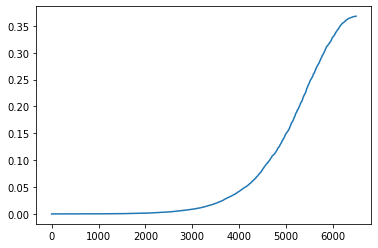

In [43]:
x = list(range(len(entropies)))
plt.plot(x, np.sort(entropies))

In [35]:
feature_train, fnames_train, categories_train = feature_extractor(model, anno_train_dl, is_train = True)

pca = PCA(n_components=2)

feature_train_pca = pca.fit_transform(sklearn.preprocessing.normalize(feature_train))
x = [item[0] for item in feature_train_pca.tolist()]
y = [item[1] for item in feature_train_pca.tolist()]
categories_train = [item.item() for item in categories_train]

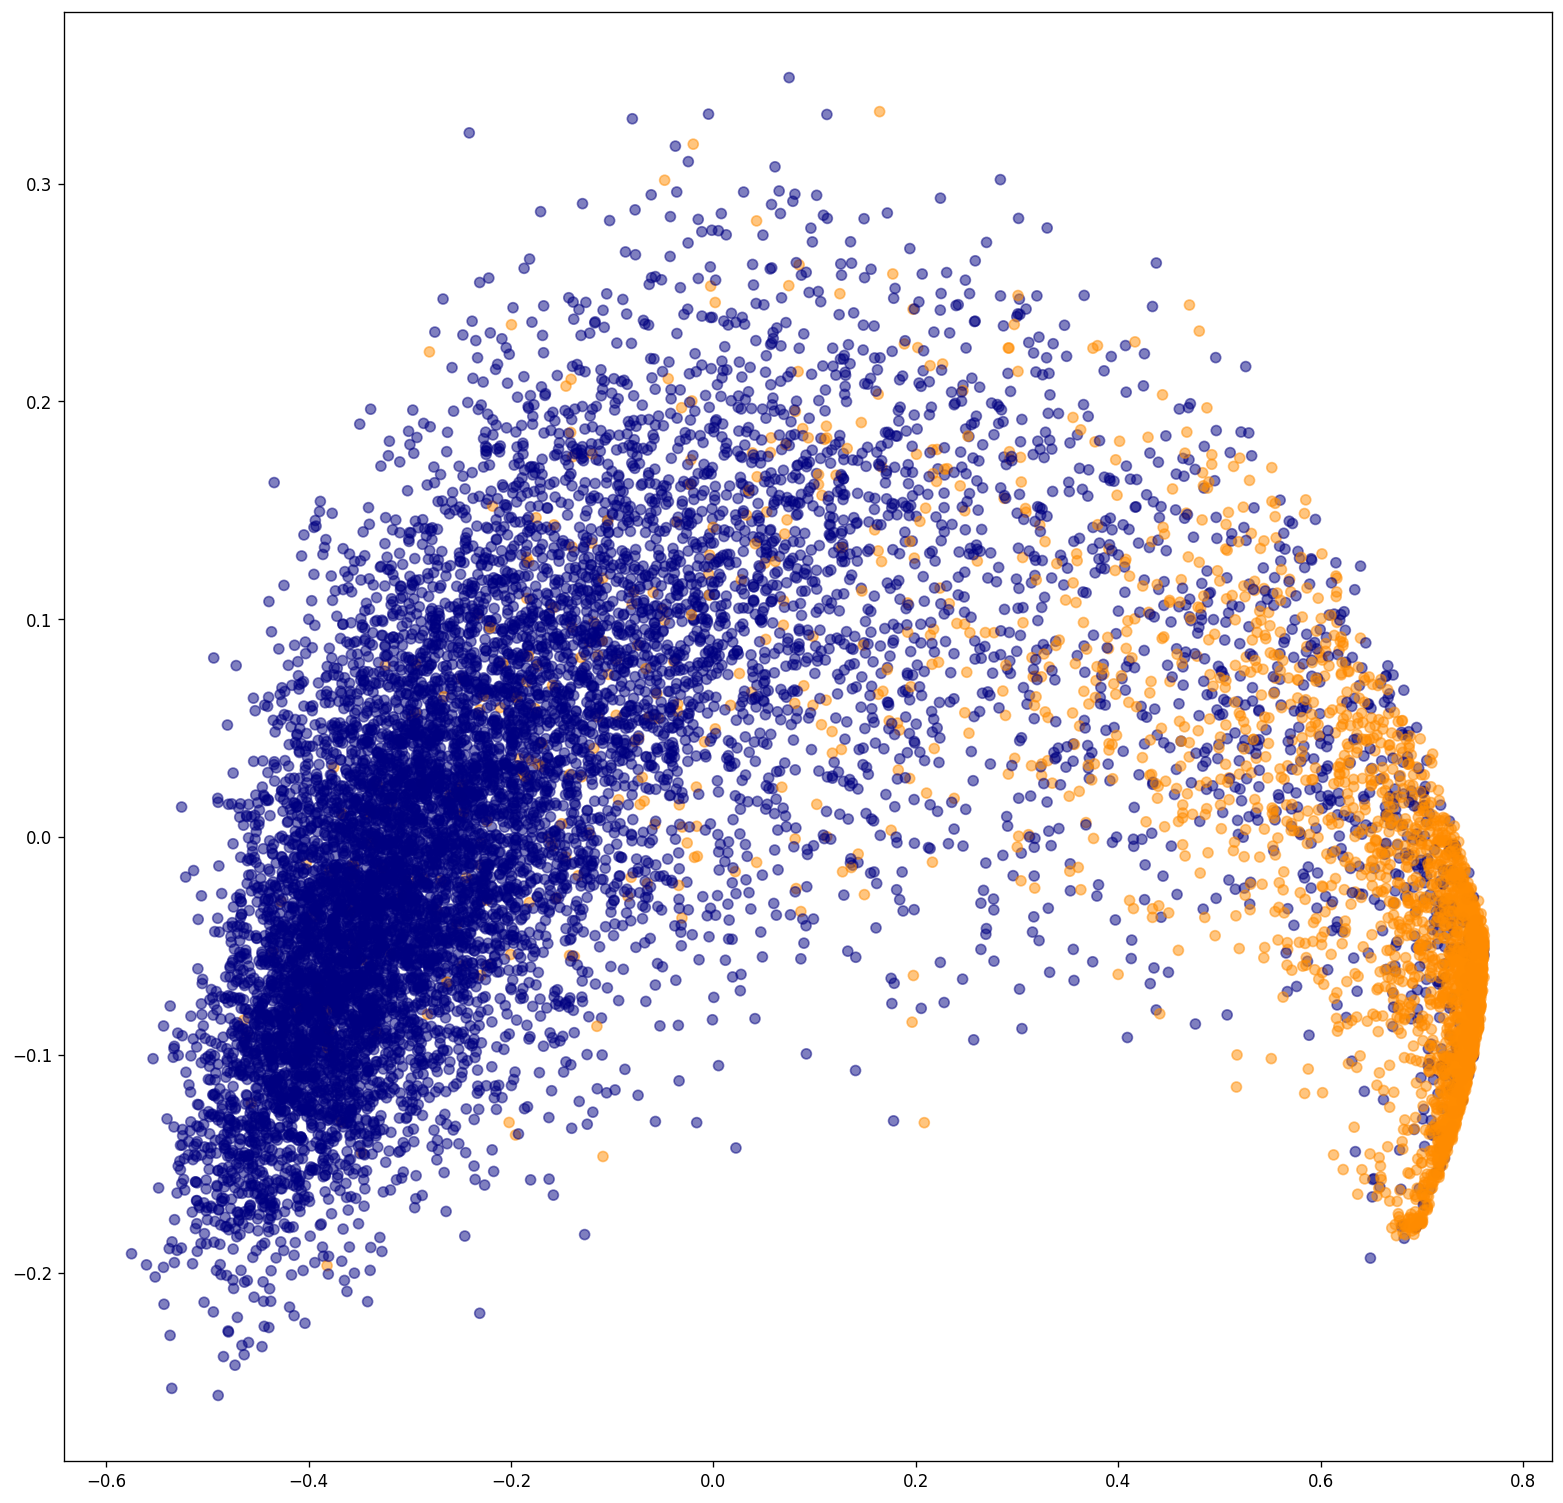

In [39]:
color = ['darkorange' if item == 1 else 'navy' for item in categories_train]
plt.figure(figsize=(16, 16), dpi=120)
plt.scatter(x, y, color=color, alpha=0.5)
plt.show()

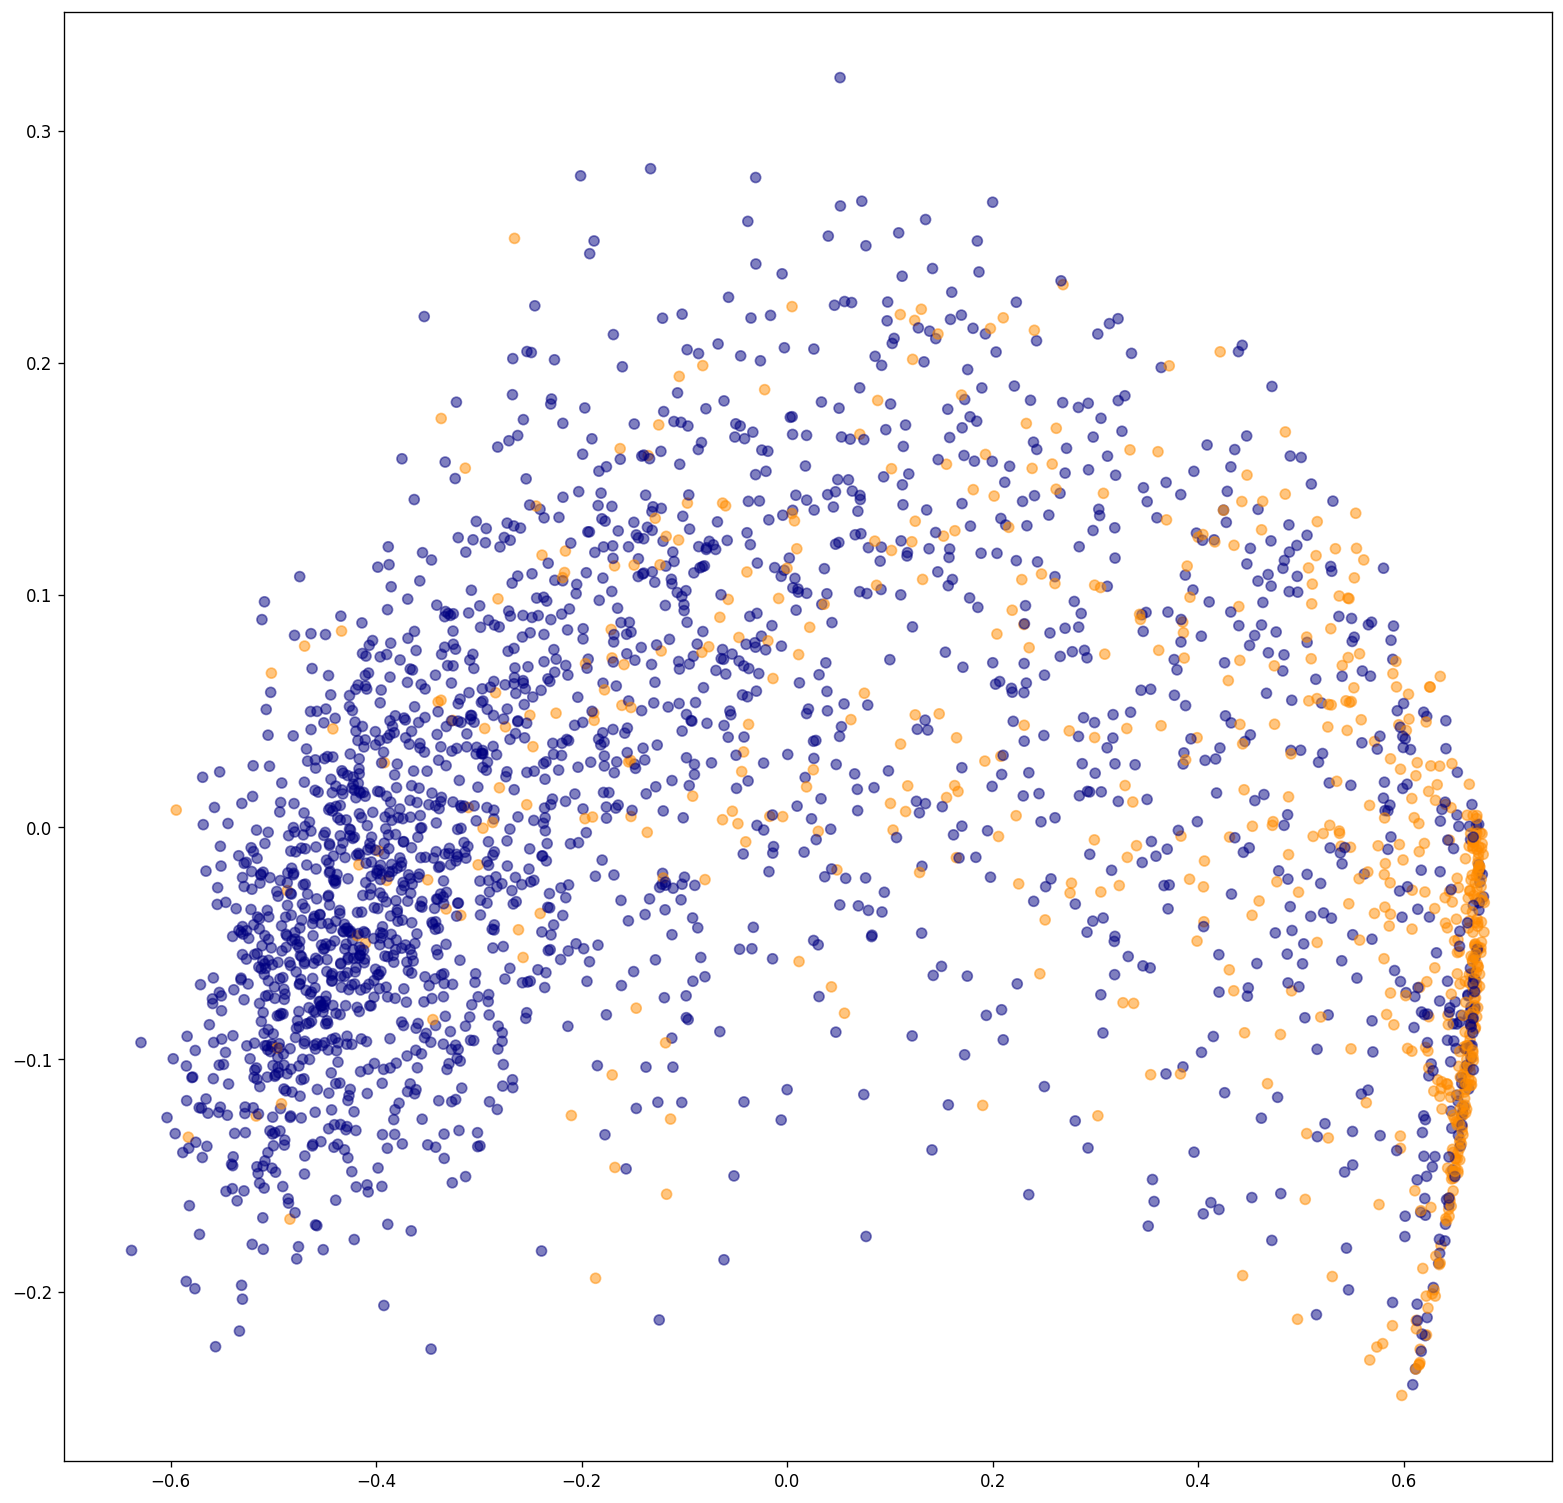

In [40]:
feature_valid, fnames_valid, categories_valid = feature_extractor(model, anno_valid_dl, is_train = True)

pca = PCA(n_components=2)

feature_valid_pca = pca.fit_transform(sklearn.preprocessing.normalize(feature_valid))

x = [item[0] for item in feature_valid_pca.tolist()]
y = [item[1] for item in feature_valid_pca.tolist()]

categories_valid = [item.item() for item in categories_valid]
color = ['darkorange' if item == 1 else 'navy' for item in categories_valid]
plt.figure(figsize=(16, 16), dpi=120)
plt.scatter(x, y, color=color, alpha=0.5)
plt.show()

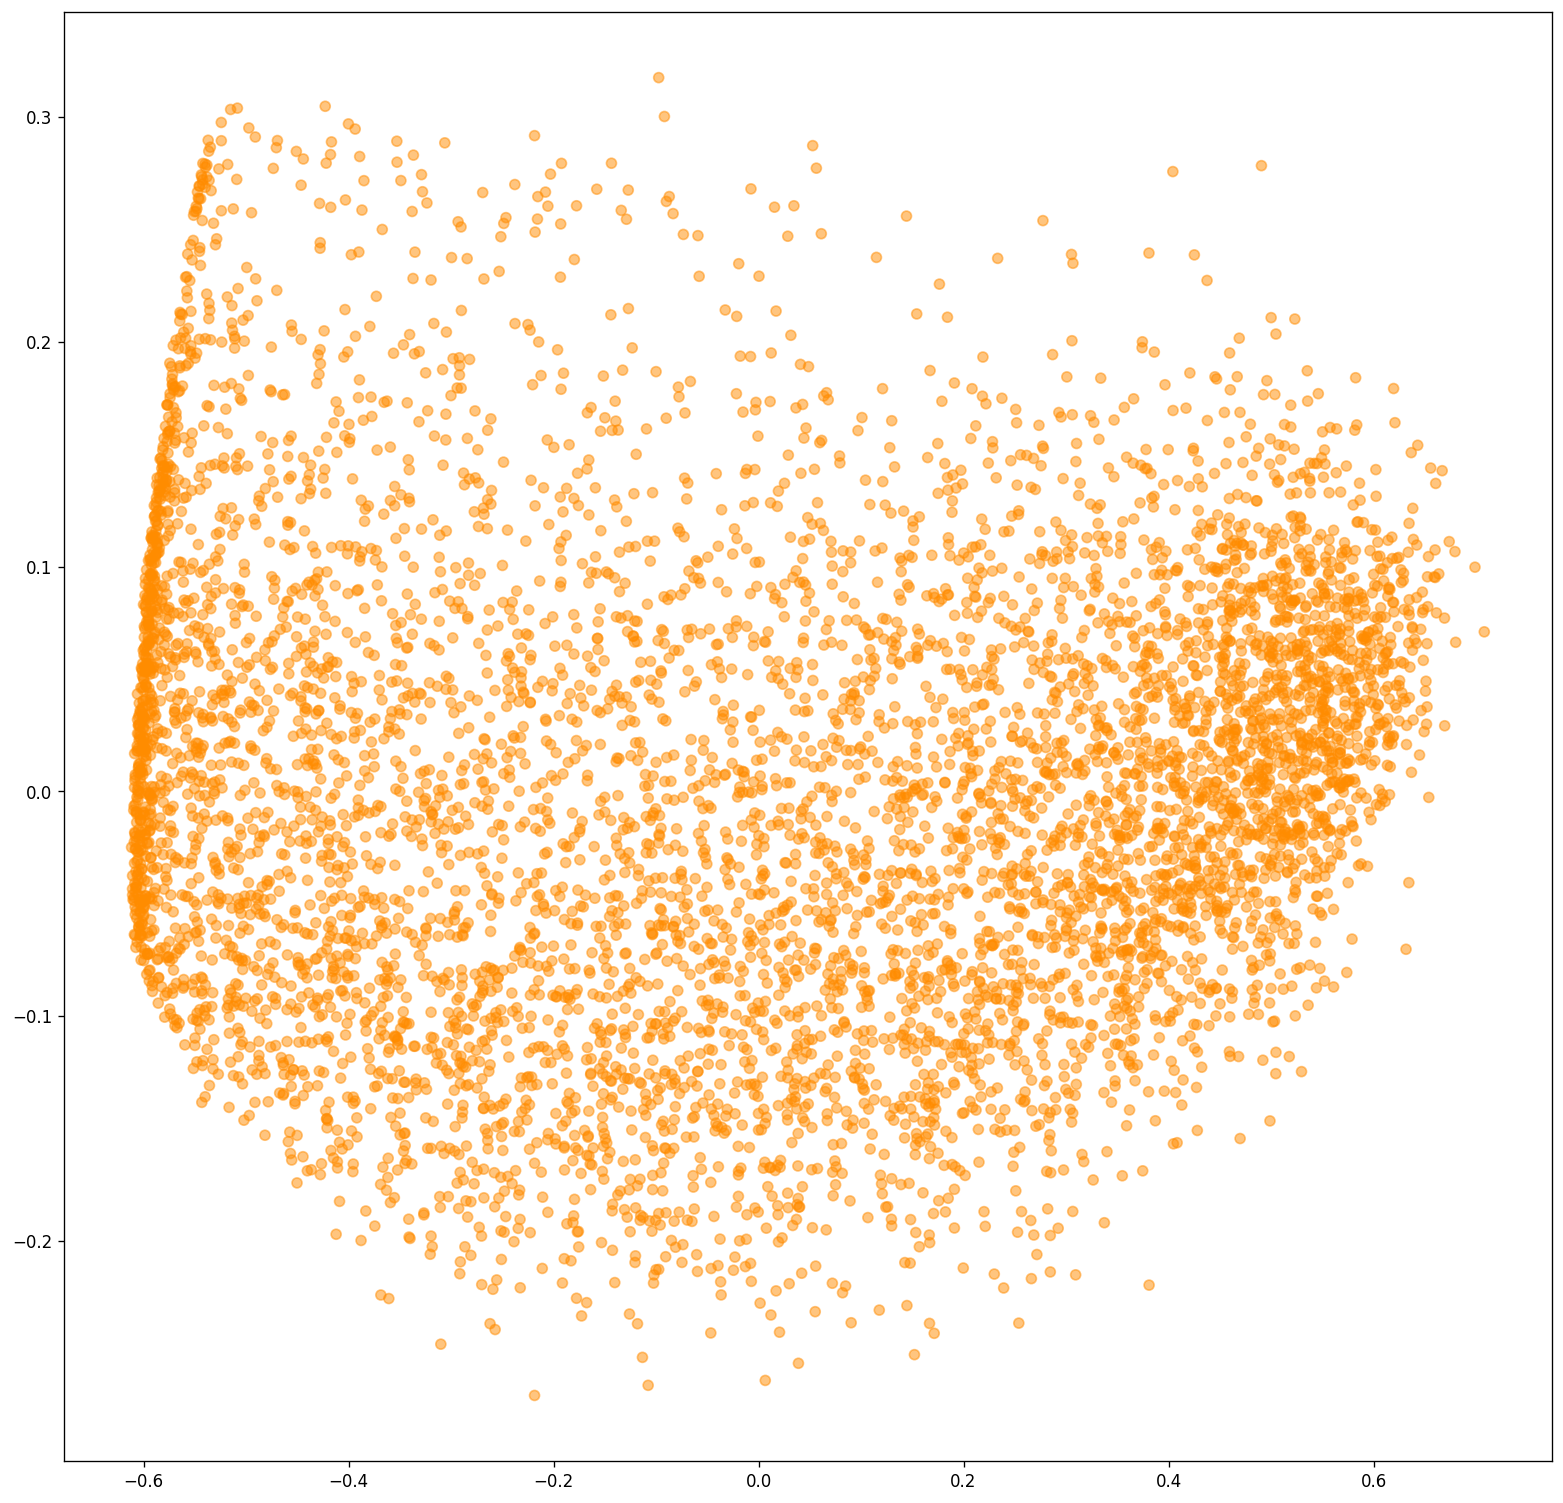

In [41]:
feature_pool, fnames_pool = feature_extractor(model, pool_dl, is_train = False)

pca = PCA(n_components=2)

feature_pool_pca = pca.fit_transform(sklearn.preprocessing.normalize(feature_pool))

x = [item[0] for item in feature_pool_pca.tolist()]
y = [item[1] for item in feature_pool_pca.tolist()]

color = ['darkorange']*len(fnames_pool)
plt.figure(figsize=(16, 16), dpi=120)
plt.scatter(x, y, color=color, alpha=0.5)
plt.show()